In [1]:
import tensorflow as tf
import numpy as np

from pinn import PINNModel, model1
from accuracy import AccuracyCalc
from plotting import NNPlots
from task import Task

2024-10-10 19:23:42.604299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 19:23:42.614336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 19:23:42.626161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 19:23:42.629842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 19:23:42.638943: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [3]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
area_grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
plotting_grid_size = (200, 200)

EPOCHS = 6000
EPRINT = 500
LOSS = 1e-1 # 1e-4

model = PINNModel(model1(), optm = tf.keras.optimizers.Adam(learning_rate=0.001))

info = Task(model.predict, real_u, (x_limits, y_limits), area_grid_size, border_grid_size)

(2500, 2) (196, 2) (2304, 2)


I0000 00:00:1728577424.883254   33411 service.cc:146] XLA service 0x78a3c4004510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728577424.883280   33411 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-10 19:23:44.901740: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step 

I0000 00:00:1728577425.276101   33411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(2500,) (2500, 1)


In [5]:
model.load_weights("../models/model0.weights.h5")
model.train(1, *info.train_info(), EPOCHS, LOSS, EPRINT)
model.save("../models/model0.weights.h5")

/home/c0c0nut/Projects/PINN_Poisson/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


epoch: 0 loss: 1.36585665
epoch: 500 loss: 0.0293786


In [6]:
# pred_coord = list()
# for _x in x[0]:
#     for _y in x[0]:
#         pred_coord.append([_x, _y])
# pred_u = model.predict(np.array(pred_coord)).ravel().reshape(plotting_grid_size[0], plotting_grid_size[1])
print("Error:", AccuracyCalc.mse(info.accuracy_info()))
print("Error:", AccuracyCalc.maxe(info.accuracy_info()))

Error: 0.3473144235978292
Error: 1.4279382360947035


In [7]:
plotter = NNPlots((x_limits, y_limits), area_grid_size, model.predict, real_u, info._predict_val)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
[[-0.07044986]
 [-0.05737799]
 [-0.04291047]
 ...
 [-0.03288744]
 [-0.03967431]
 [-0.04778899]] [[0.01812214]
 [0.02868487]
 [0.039221  ]
 ...
 [0.3578715 ]
 [0.35487902]
 [0.351773  ]]
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
(50, 50) (50, 50)


/home/c0c0nut/Projects/PINN_Poisson/src/plotting.py:89: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/c0c0nut/Projects/PINN_Poisson/src/plotting.py:110: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(
/home/c0c0nut/Projects/PINN_Poisson/src/plotting.py:140: UserWarning: The following kwargs were not used by contour: 'linestyle'
  diff.contour(


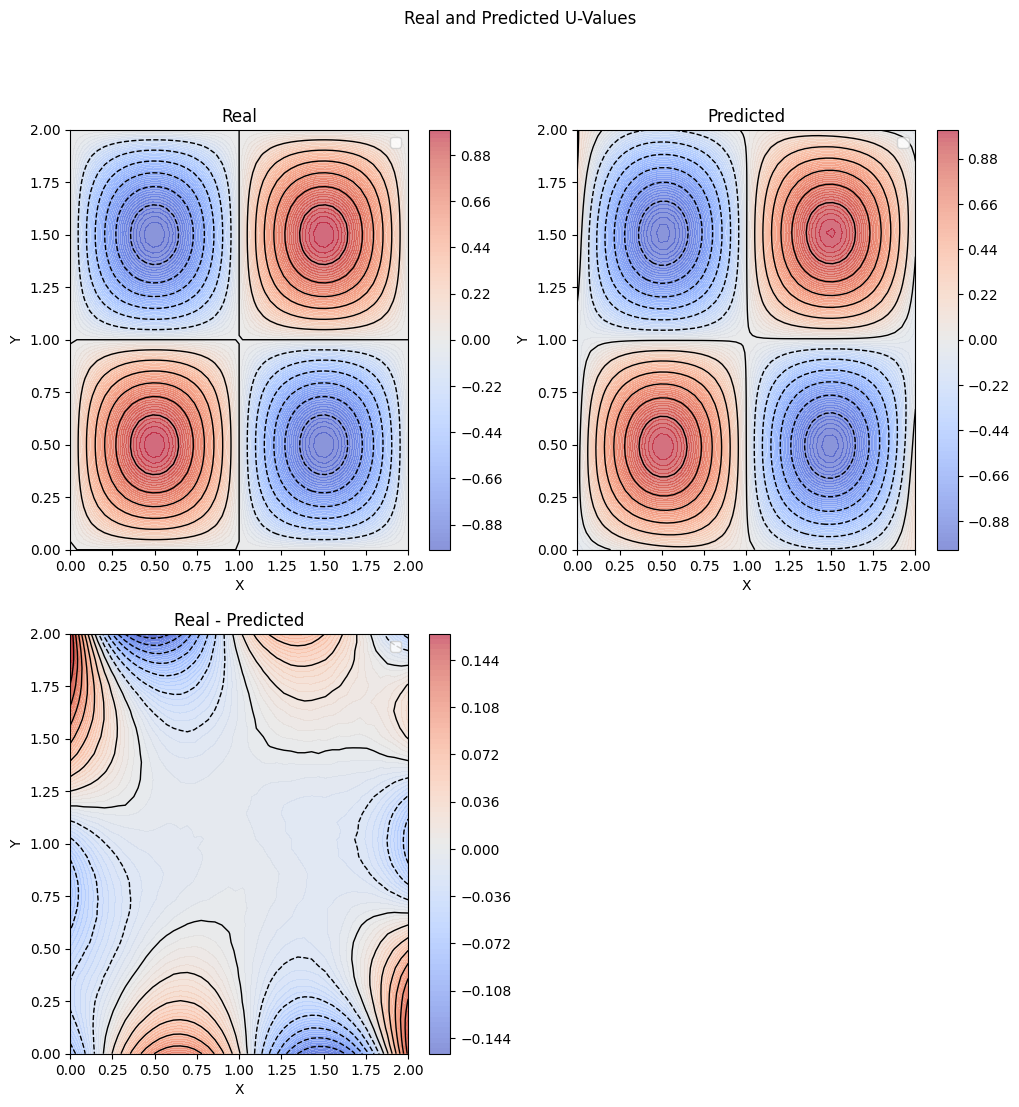

In [8]:

plotter.plot2d_contour()